## Model building

In [1]:
# importing libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder , LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
X_train = np.load('X_train_vectors.npy', mmap_mode='r')
X_test = np.load('X_test_vectors.npy', mmap_mode='r')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(394179, 768) (10108, 768) (394179,) (10108,)


In [3]:
X_tr = X_train[:100000]
y_tr = y_train[:100000]
print(X_tr.shape, y_tr.shape)

(100000, 768) (100000,)


In [4]:
def oversampling(X_train, y_train):
    """This function implement oversampling strategy to increase the number of minority class in imbalanced dataset so as 
       to balance the dataset
       
       Input  : Imbalanced Training dataset - x_train and y_train
       Output : Balanced Training dataset - x_train and y_train
    """
    # define pipeline and implement SMOTE oversampling method for minority class
    over = SMOTE(sampling_strategy=.9)
    steps = [('o', over)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_train, y_train = pipeline.fit_resample(X_train, y_train)
    return X_train, y_train

In [5]:
def score_calculations(X_valid,y_valid, model):
    """This function takes in validation data, corresponding labels and the trained ML model. It calculates auc score, 
       recall score and confusion matrix. 
       
       Input  : Validation data along with corresponding labels and trained model
       Output : AUC score, Recall score and confusion matrix score given by model on validation data
    """
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)
    auc = roc_auc_score(y_valid, y_proba[:,1])
    binary_recall = recall_score(y_valid, y_pred, average='binary')
    macro_recall = recall_score(y_valid, y_pred, average='macro')
    macro_f1 = f1_score(y_valid, y_pred, average='macro')
    cf = confusion_matrix(y_valid,y_pred)
    return auc,binary_recall,macro_recall, macro_f1, cf

In [4]:
plt.rcParams.update({'font.size': 11})
def plot_confusion_matrix(model,auc,recall,mac_recall, mac_f1,cf):
    """This function takes in model name, auc score, recall score and confusion matrix. It plots confusion matrix along with
       corresponding auc score and recall score.
       
       Input : model name, auc score, recall score(both binary and macro), macro f1 score, confusion matrix
       Output : returns nothing; prints confusion matrix,acu,recall and f1 scores
    """
    cf_matrix = cf
    group_names = ['True Negative','False Positive','False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.title('\nModel : {}\n AUC score : {:.2f}\n Recall score : {:.2f}\n Macro Recall : {:.2f}\n Macro F1 score : {:.2f}'.format(model,auc,recall,mac_recall,mac_f1), fontsize=16)
    plt.show()
    print('*************************************************\n\n\n')

In [8]:
def find_best_model(X_train,X_valid,y_train,y_valid):
    """This model takes in training data, validation data along with corresponding labels. It trains ML modles namely 
       logistic Regression, Decision Tree Classifier, Random Forest Classifier, Naive Bayes and KNN. Does hyper-parameter
       tuning, plots the confusion matrix obtained on validation data and returns the scores obtained by each model. 
       
       Input  : Training and validation data along with corresponding labels - X_train,X-valid, y_train, y_valid
       Output : Trained models along with corresponding validation auc, recall and confusion matrix scores
    """
    
    # Model 1 : Logistic Regression 
    model_1 = SGDClassifier( class_weight= 'balanced', random_state=0, loss='log')
    param_dict_1 = { 'alpha':[.001,.01,1,10], 'penalty':["l2", "elasticnet"] }
    cv_model_1 = GridSearchCV(model_1,param_grid=param_dict_1, cv=10, n_jobs=-1,verbose=1,refit='roc_auc',scoring=['roc_auc', 'recall'])
    cv_model_1.fit(X_train,y_train)
    auc_1, recall_1,mac_recall_1,mac_f1, cf_1 = score_calculations(X_valid,y_valid, cv_model_1)
    plot_confusion_matrix("Logistic Regression",auc_1,recall_1,mac_recall_1,mac_f1, cf_1)
    
    # Model 2 : Decision Tree classifier
    model_2 = DecisionTreeClassifier(class_weight="balanced",criterion="gini",  random_state=0)
    param_dict_2 = { "max_depth": [5,10,20] }
    cv_model_2 = GridSearchCV(model_2,param_grid=param_dict_2, cv=10, n_jobs=-1,verbose=1,refit='roc_auc', scoring=['roc_auc', 'recall'] )
    cv_model_2.fit(X_train,y_train)
    auc_2, recall_2,mac_recall_2,mac_f2,cf_2 = score_calculations(X_valid,y_valid, cv_model_2)
    plot_confusion_matrix("Decision Tree",auc_2,recall_2,mac_recall_2,mac_f2,cf_2)    
    
    # Model 3 : Random Forest Classifier 
    model_3 = RandomForestClassifier(random_state=0, class_weight="balanced",criterion="gini")
    param_dict_3 = { 'max_depth':[ 3,5,7 ] ,'n_estimators': [200,400] }
    cv_model_3 = GridSearchCV(model_3,param_grid=param_dict_3, cv=3, n_jobs=-1,verbose=1,refit='roc_auc', scoring=['roc_auc', 'recall'] )
    cv_model_3.fit(X_train,y_train)
    auc_3, recall_3,mac_recall_3,mac_f3, cf_3 = score_calculations(X_valid,y_valid, cv_model_3)
    plot_confusion_matrix("Random Forest",auc_3,recall_3,mac_recall_3,mac_f3, cf_3)    
    
    # oversampling the minority class datapoints
    X_train, y_train =  oversampling(X_tr, y_train)
    
    # Model 4 : Naive Bayes
    model_4 = BernoulliNB()
    param_dict_4 = {'alpha': [0.1, 0.5, 1.0, 5.] }
    cv_model_4=  GridSearchCV(model_4,param_grid=param_dict_4, cv=10, n_jobs=-1,verbose=1,refit='recall', scoring=['roc_auc', 'recall'] )
    cv_model_4.fit(X_train,y_train)
    auc_4, recall_4, mac_recall_4,mac_f4, cf_4 = score_calculations(X_valid,y_valid, cv_model_4)
    plot_confusion_matrix("Naive Bayes",auc_4,recall_4,mac_recall_4,mac_f4, cf_4) 

    # Model 5 : KNN
    model_5 = KNeighborsClassifier(weights="distance", metric= "minkowski", p = 2)
    param_dict_5 = { 'n_neighbors' : [3,5,7 ] }
    cv_model_5= GridSearchCV(model_5,param_grid=param_dict_5, cv=5, n_jobs=-1,verbose=1,refit='roc_auc', scoring=['roc_auc', 'recall'] )
    cv_model_5.fit(X_train,y_train)
    auc_5, recall_5,mac_recall_5,mac_f5, cf_5 = score_calculations(X_valid,y_valid, cv_model_5)
    plot_confusion_matrix("KNN",auc_5,recall_5,mac_recall_5,mac_f5,cf_5)
    
    auc_list = [auc_1, auc_2, auc_3, auc_4, auc_5]
    recall_list = [ recall_1, recall_2, recall_3, recall_4, recall_5 ]
    mac_recall_list = [ mac_recall_1, mac_recall_2, mac_recall_3, mac_recall_4, mac_recall_5  ]
    mac_f1_list = [mac_f1,mac_f2, mac_f3, mac_f4, mac_f5 ]
    cf_list = [cf_1, cf_2, cf_3, cf_4, cf_5 ]
    model_names = ["Logistic Reg","Decision Trees","Random Forest","Naive Bayes","KNN"]
    model_list = [ cv_model_1, cv_model_2, cv_model_3, cv_model_4, cv_model_5 ]
    
    return auc_list,recall_list,mac_recall_list, mac_f1_list, cf_list,model_names, model_list

Fitting 10 folds for each of 8 candidates, totalling 80 fits


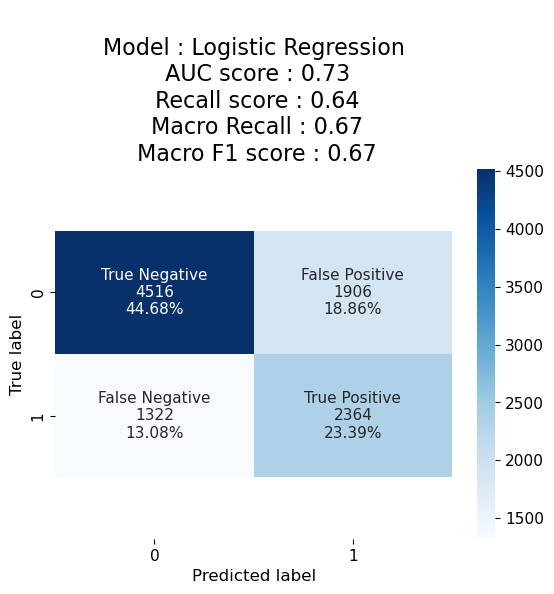

*************************************************



Fitting 10 folds for each of 3 candidates, totalling 30 fits


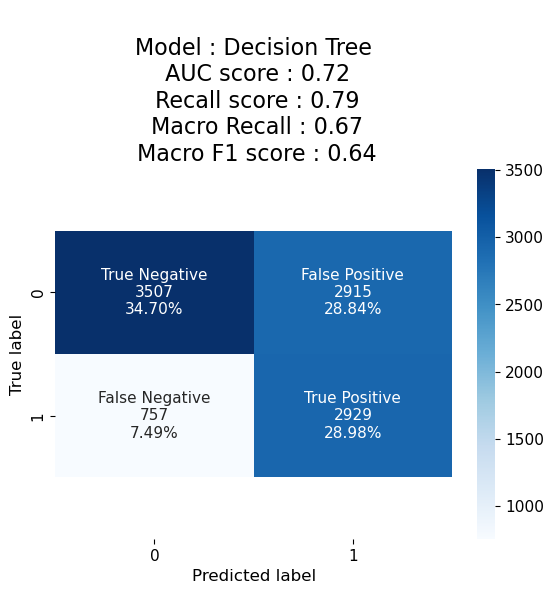

*************************************************



Fitting 3 folds for each of 6 candidates, totalling 18 fits


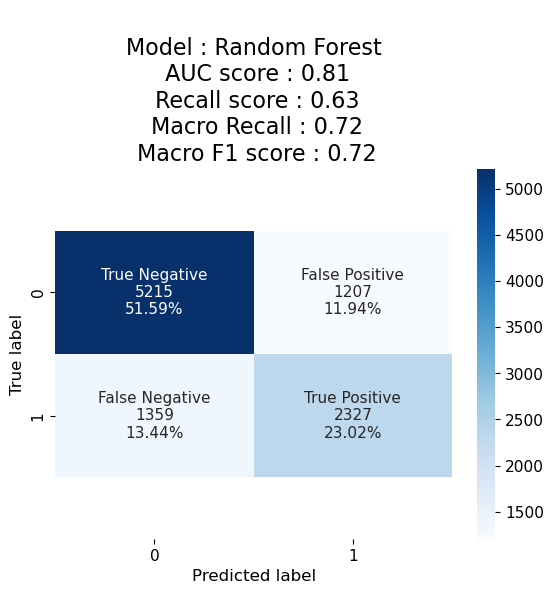

*************************************************



Fitting 10 folds for each of 4 candidates, totalling 40 fits


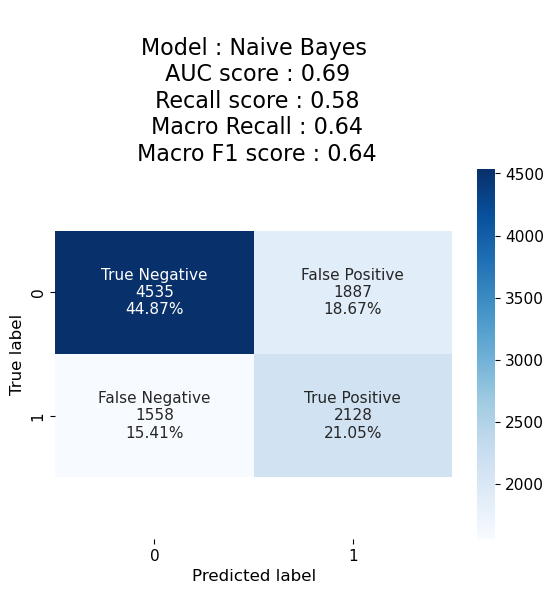

*************************************************



Fitting 5 folds for each of 3 candidates, totalling 15 fits


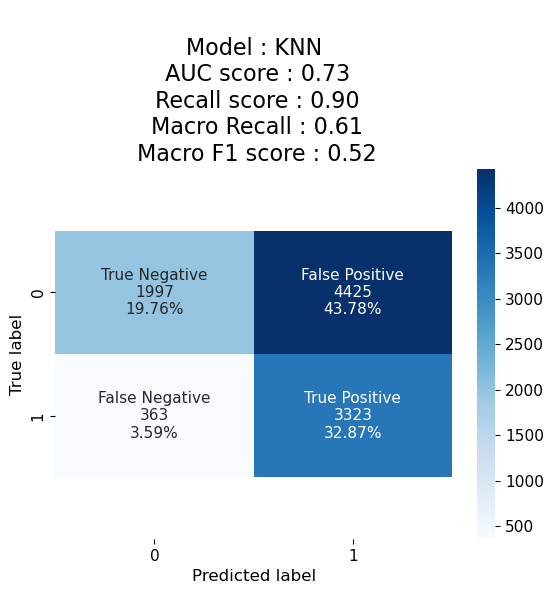

*************************************************





In [9]:
auc_list, recall_list, mac_recall_list, mac_f1_list, cf_list, model_names, model_list = find_best_model(X_tr,X_test,y_tr,y_test)

In [10]:
def plot_models_score_barplot(auc_list,recall_list,macro_recall, macro_f1, model_names):
    """This function takes in list of auc scores, recall scores and model names. It plots a join-bar char of auc scores and 
       recall scores
       
       input  : auc score list, recall score list, model names list
       output : returns nothing; plots bar chart
    """
    # Numbers of pairs of bars you want
    N = len(auc_list)
    # Data on X-axis
    # Specify the values of blue bars (height)
    blue_bar = auc_list
    # Specify the values of orange bars (height)
    orange_bar = recall_list
    # Specify the values of green bar
    green_bar = macro_recall
    # Specify the valeus of pink bar
    pink_bar = macro_f1
    # Position of bars on x-axis
    ind = np.arange(N)
    # Figure size
    plt.figure(figsize=(15,10))
    # Width of a bar 
    width = 0.2       
    # Plotting
    plt.bar(ind, blue_bar , width, label='AUC score')
    plt.bar(ind + width, orange_bar, width, label='Recall score')
    plt.bar(ind+ (2*width), green_bar, width, label = 'Macro Recall')
    plt.bar(ind+ (3*width), pink_bar, width, label = 'Macro F1')
    plt.xlabel('Machine learning models', fontsize=13)
    plt.ylabel('Scores', fontsize=13)
    plt.title('Comparative study of Machine Learning Models', fontsize=14)
    # xticks()
    # First argument - A list of positions at which ticks should be placed
    # Second argument -  A list of labels to place at the given locations
    plt.xticks(ind + width / 2,model_names, fontsize=13)
    # Finding the best position for legends and putting it
    plt.legend(loc='best', fontsize=13)
    plt.show()

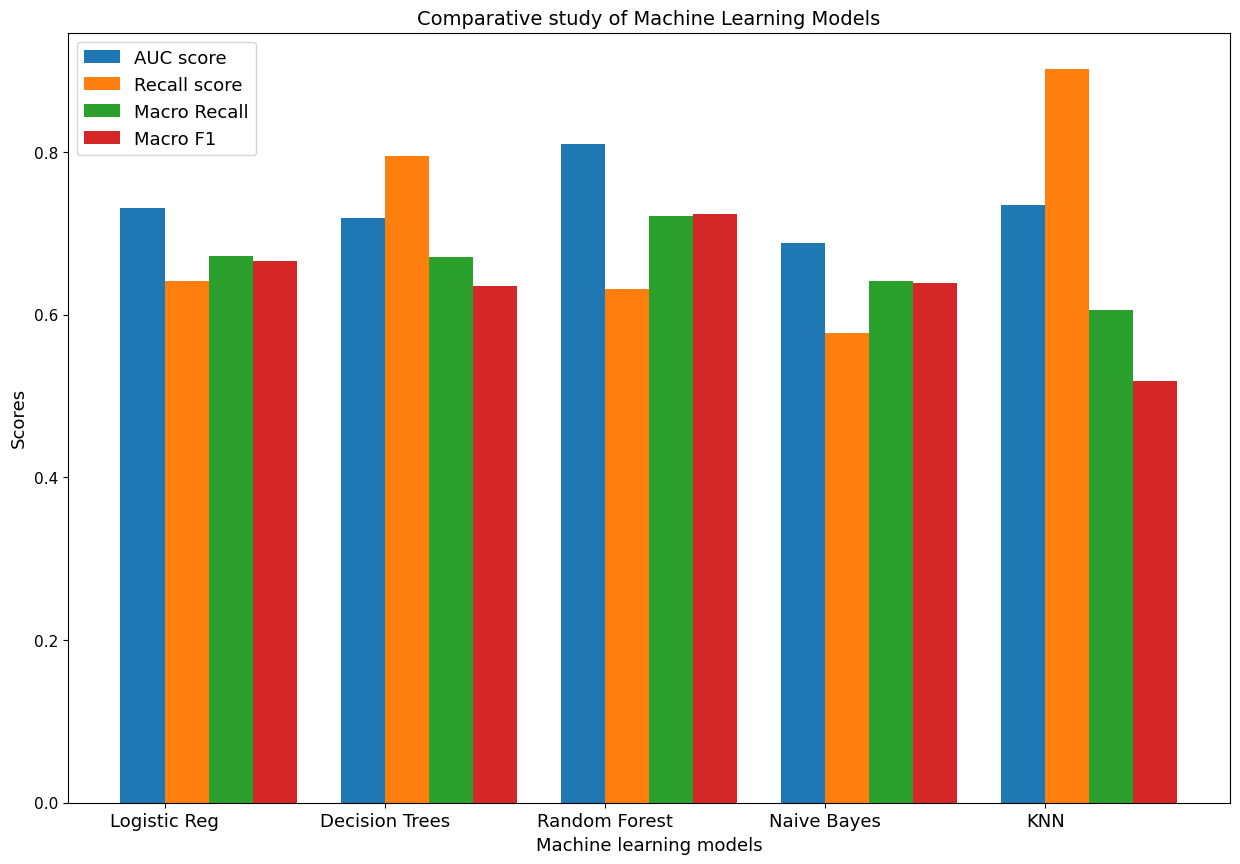

In [12]:
plot_models_score_barplot(auc_list, recall_list, mac_recall_list, mac_f1_list, model_names)

Random forest achieves the highest AUC score. So, we will be using Random Forest Model as our final model. 

In [13]:
model_list

[GridSearchCV(cv=10,
              estimator=SGDClassifier(class_weight='balanced', loss='log',
                                      random_state=0),
              n_jobs=-1,
              param_grid={'alpha': [0.001, 0.01, 1, 10],
                          'penalty': ['l2', 'elasticnet']},
              refit='roc_auc', scoring=['roc_auc', 'recall'], verbose=1),
 GridSearchCV(cv=10,
              estimator=DecisionTreeClassifier(class_weight='balanced',
                                               random_state=0),
              n_jobs=-1, param_grid={'max_depth': [5, 10, 20]}, refit='roc_auc',
              scoring=['roc_auc', 'recall'], verbose=1),
 GridSearchCV(cv=3,
              estimator=RandomForestClassifier(class_weight='balanced',
                                               random_state=0),
              n_jobs=-1,
              param_grid={'max_depth': [3, 5, 7], 'n_estimators': [200, 400]},
              refit='roc_auc', scoring=['roc_auc', 'recall'], verbose=1),
 Gri

In [15]:
model_list[2].best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=400,
                       random_state=0)

In [4]:
# Final Random Forest Classifier 
model = RandomForestClassifier(random_state=0, class_weight="balanced",criterion="gini")
param_dict = { 'max_depth':[ 7,9 ] ,'n_estimators': [400, 500 ] }
cv_model = GridSearchCV(model,param_grid=param_dict, cv=3, n_jobs=-1,verbose=1,refit='neg_log_loss', scoring=['neg_log_loss'] )
cv_model.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [7, 9], 'n_estimators': [400, 500]},
             refit='neg_log_loss', scoring=['neg_log_loss'], verbose=1)

In [8]:
cv_model.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=500,
                       random_state=0)

In [11]:
#pickle.dump(cv_model, open('RFC_tuned.sav', 'wb'))
#pickle.dump(model, open('RFC.sav', 'wb'))

In [6]:
filename = 'RFC_tuned.sav'
loaded_model = pickle.load(open(filename, 'rb'))

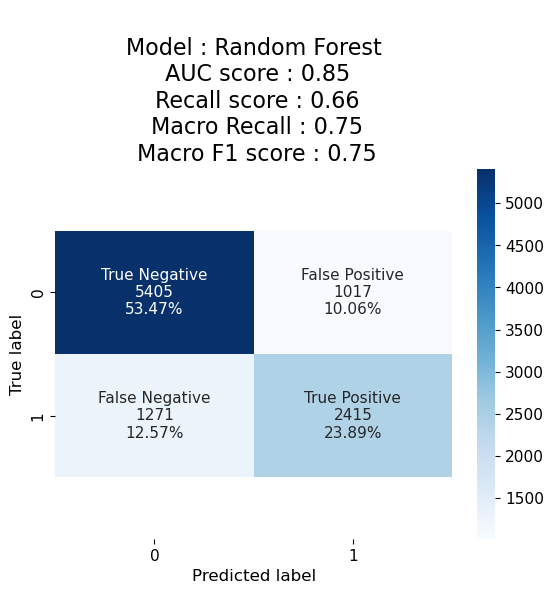

*************************************************





In [8]:
auc, recall, mac_recall,mac, cf = score_calculations(X_test, y_test, loaded_model)
plot_confusion_matrix("Random Forest",auc, recall, mac_recall,mac, cf) 

In [12]:
predicted_proba = loaded_model.predict_proba(X_test)
log_loss(y_test, predicted_proba)

0.5990292065688